In [1]:
import pandas as pd
import numpy as np
import matplotlib

In [2]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


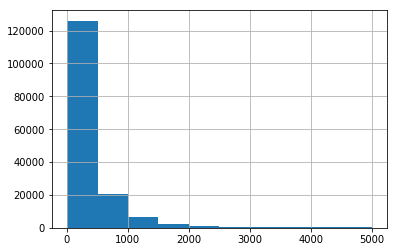

In [4]:
%matplotlib inline
comment_lens = df.comment_text.str.len()
comment_lens.hist()

In [5]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['none'] = 1-df[label_cols].max(axis=1)
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df.shape

(159571, 9)

In [7]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [8]:
import re
import string

re_toke = re.compile('([{}""¨«»®´·º½¾¿¡§£₤''])'.format(string.punctuation))

def tokenize(s): 
    return re_toke.sub(r' \1 ', s).split()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline

In [10]:
n = df.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=4, 
                      max_df=0.9, strip_accents='unicode', use_idf=1, 
                      smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(df.comment_text)
test_term_doc = vec.transform(test.comment_text)

In [ ]:
x = trn_term_doc
test_x = test_term_doc
x.shape

In [12]:
#from sklearn.decomposition import TruncatedSVD
#from matplotlib import pyplot as plt

In [ ]:
#svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
#svd.fit(x)
#svd.explained_variance_ratio_

In [13]:
def pr(y_i, y):
    """ Given a class value for y, calculate the sum of all X features, then normalize 
    by the total number of y class instanaces.  AKA given y, find the probability of X(i) """
    p = x[y == y_i].sum(0)
    return (p + 1) / ((y == y_i).sum() + 1)

In [14]:
def get_mdl(y, model, params, cross_val, gs_scoring='accuracy', gs_verbose=True):
    y = y.values
    r = np.log(pr(1, y) / pr(0,y)) # finding the log of the ratio of each X feature count conditioned on the target class.
    #m = model
    x_nb = x.multiply(r) # multiply x feature array by the log count ratio for the class
    # run grid search for each class to tune parameters:
    grid_search_clf = GridSearchCV(model,
                           n_jobs=2,
                           param_grid=params, 
                           cv=cross_val,
                           scoring=gs_scoring, # optimize for recall because the toxic classes are a minority
                           verbose=gs_verbose)
    fitted = grid_search_clf.fit(x_nb, y)
    print(fitted.best_params_)
    print(fitted.best_score_)
    return fitted, r

In [ ]:
preds = np.zeros((len(test), len(label_cols)))
clf = LogisticRegression()

param_values = {
    'C': np.linspace(0.5, 1.5, 5)
}

RANDOM_STATE = 1234
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
#smote = SMOTE(random_state=RANDOM_STATE)

for i, j in enumerate(label_cols):
    print('fit', j)
    m, r = get_mdl(y=df[j], model=clf, params=param_values, cross_val=cv) # df[j] is the column vector with 1/0 labels for each comment type.
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [19]:
submission = pd.concat([test['id'], pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)